### 26. juni

Lager et script som kun trener nettverket med bilder av tall fra 0-3 og prøver deretter å legge bilder av 4 inn i trenignssettet, og så 5 og 6 osv. Dette gjør jeg for å kunne se på hvordan vektendringen utvikler seg ved gradvis læring. 

In [1]:
import torch
import copy
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
input_dim = 28**2  # MNIST images are 28x28 pixels
hidden_dim1 = 128  # Number of units in the first hidden layer
hidden_dim2 = 100  # Number of units in the second hidden layer
learning_rate = 0.001
num_epochs = 30
output_dim = 4  # initial output classes (digits 0-3)
batch_size = 30

# Set the seed for reproducibility
torch.manual_seed(42)

In [3]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [4]:
class Data(Dataset):
    def __init__(self, dataset):
        self.x, self.y = dataset.data, dataset.targets
        self.x = self.x / 255.0
        # self.y = F.one_hot(self.y, num_classes=10).to(float) # = 10 siden tall fra 0-9

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [5]:
train_ds = Data(train_dataset)
test_ds = Data(test_dataset)

In [6]:
# Filter out images and labels for digits 4-9
train_mask = train_ds.y <= 3
test_mask = test_ds.y <= 3
train_ds.y = train_ds.y[train_mask]
train_ds.x = train_ds.x[train_mask]
test_ds.y = test_ds.y[test_mask]
test_ds.x = test_ds.x[test_mask]

# Define the data loaders
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [7]:
len(test_ds)

4157

In [8]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        self.R = nn.ReLU()

    def forward(self, x):
        x = self.R(self.layer1(x))
        x = self.R(self.layer2(x))
        x = self.layer3(x)
        return x


In [9]:
model = NeuralNet()

In [10]:
# Define loss and optimizer functions
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [11]:
# Lager test-data for å ta i bruk lengre nede i loopen.
x_test = test_ds.x.reshape(-1, input_dim).float()
y_test = test_ds.y

In [12]:
epochs = []
avg_weight_changes = []
losses = []
accuracy = []

# Create a copy of the initial model state
initial_state = copy.deepcopy(model.state_dict())

# Create dictionaries to store the weight differences for each layer
layer_weight_differences = {layer_name: [] for layer_name, _ in model.named_parameters()}

for epoch in range(num_epochs):
    N = len(train_loader)
    # Check if it's time to add a new digit
    if epoch == 10:
        # Filter out images and labels for digit 4
        train_mask = (train_ds.y <= 4)
        test_mask = (test_ds.y <= 4)
        train_ds.y = train_ds.y[train_mask]
        train_ds.x = train_ds.x[train_mask]
        test_ds.y = test_ds.y[test_mask]
        test_ds.x = test_ds.x[test_mask]

    if epoch == 20:
        # Filter out images and labels for digit 5
        train_mask = (train_ds.y <= 5)
        test_mask = (test_ds.y <= 5)
        train_ds.y = train_ds.y[train_mask]
        train_ds.x = train_ds.x[train_mask]
        test_ds.y = test_ds.y[test_mask]
        test_ds.x = test_ds.x[test_mask]

    # Reset the model to initial state
    model.load_state_dict(copy.deepcopy(initial_state))

    # Train the model
    model.train()

    for i, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        x_batch = x_batch.view(-1, input_dim)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # Store training data
        epochs.append(epoch + i / N)
        losses.append(loss.item())

    # Evaluate the model
    model.eval()
    output = model(x_test)
    acc = (torch.argmax(output, 1) == y_test).float().mean()
    accuracy.append(acc.item())

    print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {acc.item()}")


    # Calculate weight difference for each layer
    total_weight_change = 0
    total_weights = 0
    for layer_name, layer_weights in model.named_parameters():
        if "weight" in layer_name:
            prev_weights = initial_state[layer_name]
            current_weights = layer_weights.data
            difference = torch.abs(current_weights - prev_weights)
            layer_weight_differences[layer_name].append(difference.mean().item())

            # Calculate weight change in each layer
            weight_change = torch.abs(current_weights - prev_weights).sum().item()
            total_weight_change += weight_change
            total_weights += current_weights.numel()

    average_weight_change = total_weight_change / total_weights
    avg_weight_changes.append(average_weight_change)

    # Update initial state for the next epoch
    initial_state = copy.deepcopy(model.state_dict())


Epoch 0, Loss: 1.3482860326766968, Accuracy: 0.46764492988586426
Epoch 1, Loss: 1.290312647819519, Accuracy: 0.7252826690673828
Epoch 2, Loss: 1.2049640417099, Accuracy: 0.808515727519989
Epoch 3, Loss: 1.119174838066101, Accuracy: 0.8263170719146729
Epoch 4, Loss: 0.9864857196807861, Accuracy: 0.8583112955093384
Epoch 5, Loss: 0.8548818826675415, Accuracy: 0.8915082812309265
Epoch 6, Loss: 0.6013226509094238, Accuracy: 0.9083473682403564
Epoch 7, Loss: 0.6494430303573608, Accuracy: 0.9268703460693359
Epoch 8, Loss: 0.38928043842315674, Accuracy: 0.9364926815032959
Epoch 9, Loss: 0.4266554117202759, Accuracy: 0.940341591835022
Epoch 10, Loss: 0.32030564546585083, Accuracy: 0.944190502166748
Epoch 11, Loss: 0.31580638885498047, Accuracy: 0.949482798576355
Epoch 12, Loss: 0.22224630415439606, Accuracy: 0.953331708908081
Epoch 13, Loss: 0.1664806604385376, Accuracy: 0.9559778571128845
Epoch 14, Loss: 0.2512945532798767, Accuracy: 0.9591051340103149
Epoch 15, Loss: 0.22345829010009766, Acc

In [13]:
# Turning lists to arrays for flexibility
epochs = np.array(epochs)
losses = np.array(losses)
accuracy = np.array(accuracy)
average_weight_changes = np.array(avg_weight_changes)

In [14]:
# Reshaping before plotting to get same dimentions
epoch_data_avgd = epochs.reshape(num_epochs, -1).mean(axis=1)
loss_data_avgd = losses.reshape(num_epochs, -1).mean(axis=1)
accuracy = accuracy.reshape(num_epochs, -1).mean(axis=1)

In [15]:
plt.rcParams.update({'font.size': 12})

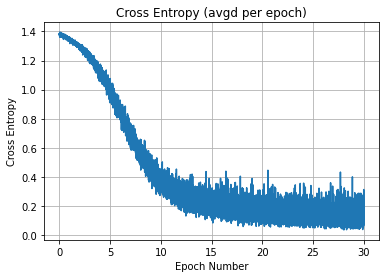

In [16]:
plt.plot(epochs, losses)
plt.grid()
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy (avgd per epoch)")
plt.show()

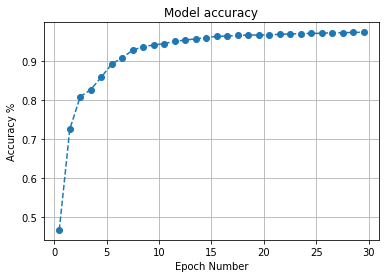

In [17]:
plt.plot(epoch_data_avgd, accuracy,"o--")
plt.grid()
plt.title("Model accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy %")
plt.show()

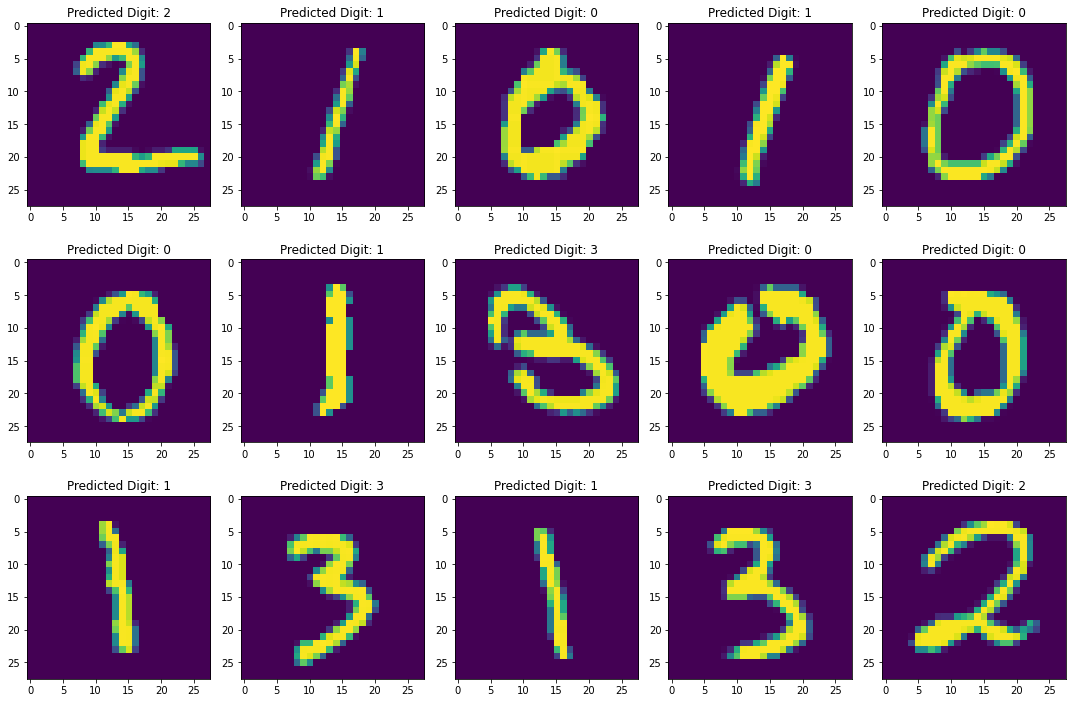

In [18]:
xs, ys = test_ds[:2000]
yhats = model(xs.view(-1, input_dim)).argmax(axis=1)

fig, ax = plt.subplots(10,4,figsize=(15,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()

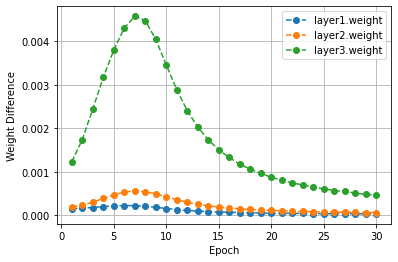

In [19]:
# Get the max number of weight differences across all layers
max_weight_differences = max(len(weight_differences) for weight_differences in layer_weight_differences.values())

# Generate the x-axis epoch data
epoch_data_avgd = np.linspace(1, num_epochs, max_weight_differences)

# Plot epoch vs. weight difference for each layer
for layer_name, weight_differences in layer_weight_differences.items():
    if "weight" in layer_name:
        plt.plot(epoch_data_avgd[:len(weight_differences)], weight_differences, "o--", label=layer_name)

plt.xlabel("Epoch")
plt.ylabel("Weight Difference")
plt.grid()
plt.legend()
plt.show()

### 27. juni

Fullførte koden for gradvis læring (ovenfor) ved å legge inn 4 og 5 i treningssettet ved epoch 10 og 20. Fikk derimot et merkelig output med en gaussisk fordeling som kan sees nedenfor. Hadde forventet at vektendringen skulle øke der som jeg legger til bilder av nye tall som er ved epoke 10 og epoke 20. Hvorfor dette ikke skjer ser jeg videre på senere.

For å ta en pause fra scriptet og heller se på det med et nytt perspektiv senere fikk jeg lagret all koden i en github-repo for å enklere kunne samarbeide med de to andre jeg skal jobbe med. 

Hadde et møte med de to andre jeg skal jobbe med der jeg oppdaterte dem på hva jeg hadde gjort til nå og de fortalte meg om hva de skulle jobbe med.

Leste deler av artikkelen "Self-Organised Learning in the Chialvo-Bak Model" av Marco Brigham, men fant ut at den handlet om en litt annen nettverksimplementasjon enn det jeg holder på med så skummet bare gjennom. Uansett kult konsept om WTA og synaptic depression.

Prøvde å gjenskape plottet i artikkelen for vekter som funksjon av nodeindeksen som vist i plottene nederst i filen 23-24_06_23.ipynb.